In [2]:
%pylab inline --no-import-all
from scikits.audiolab import wavread
from scipy import signal
import matplotlib.pyplot as plt
from scipy.io import wavfile
import math
import numpy as np
from numpy.fft import fft
import pylab

def time(data,rate):
    n=float(data.shape[0]) 
    time= numpy.arange(0, n, 1)
    time = time /rate
    time = time * 100
    return time

def plot(time,data,name):
    plt.plot(time, data, color='G')
    plt.xlabel('Time (ms)')
    plt.ylabel(name)
    plt.show()



Populating the interactive namespace from numpy and matplotlib


(120000, 2)


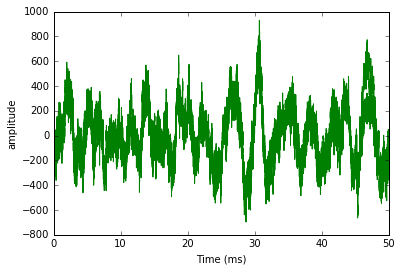

In [7]:
import numpy
import scipy.io.wavfile
from scipy.fftpack import dct
filename="/Users/kimtaing/Documents/github/MLBD/MLBD/birdsong/NonBecasse/a855.wav"
#filename='/Users/kimtaing/Documents/github/MLBD/MLBD/birdsong/Becasse/3h1.wav'
sample_rate, signal = scipy.io.wavfile.read(filename)  # File assumed to be in the same directory
print signal.shape
signal = signal[int(2.5 * sample_rate):int(3.0 * sample_rate)]   #[0:int(3.5 * sample_rate)]  # Keep the first 3.5 seconds
n=float(signal.shape[0]) 
time= numpy.arange(0, n, 1)
time = time /sample_rate
time = time * 100
plot(time,signal,"amplitude")


In [123]:
dataaudio=signal[:,0]
from IPython.display import Audio
Audio(data=dataaudio,rate=sample_rate)

(24000,)
(12000, 2)


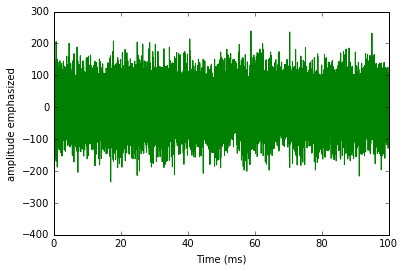

In [6]:
pre_emphasis = 0.97
emphasized_signal = numpy.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])
print emphasized_signal.shape
print signal.shape
n=float(emphasized_signal.shape[0])
time= numpy.arange(0, n, 1)
time = time /sample_rate
time = time * 100
plot(time,emphasized_signal,"amplitude emphasized")

In [126]:
dataaudio=emphasized_signal
from IPython.display import Audio
Audio(data=dataaudio,rate=sample_rate)

signal_length :  24000
frame_length :  600
frame_step :  240
num_frames :  98
(98, 600)
(98, 600)
(98, 600)
(600,)
(98,)


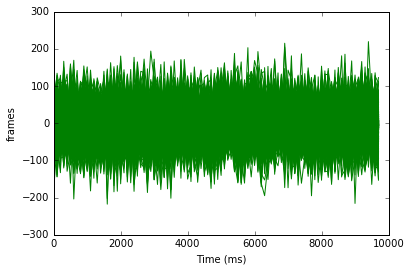

In [8]:
frame_size = 0.025 #25 ms for the frame size
frame_stride = 0.01 #15 ms overlap
frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate  # Convert from seconds to samples
signal_length = len(emphasized_signal)
frame_length = int(round(frame_length))
frame_step = int(round(frame_step))
num_frames = int(numpy.ceil(float(numpy.abs(signal_length - frame_length)) / frame_step))  # Make sure that we have at least 1 frame

print "signal_length : ",signal_length
print "frame_length : ",frame_length
print "frame_step : ",frame_step
print "num_frames : ",num_frames


pad_signal_length = num_frames * frame_step + frame_length
z = numpy.zeros((pad_signal_length - signal_length))
pad_signal = numpy.append(emphasized_signal, z) # Pad Signal to make sure that all frames have equal number of samples without truncating any samples from the original signal

indices = numpy.tile(numpy.arange(0, frame_length), (num_frames, 1)) + numpy.tile(numpy.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
frames = pad_signal[indices.astype(numpy.int32, copy=False)]
print frames.shape

print frames.shape


frames *= numpy.hamming(frame_length)
print frames.shape
print frames[1,:].shape

n=float(frames.shape[0]) 
time= numpy.arange(0, n, 1)
#time = time /600
time = time * 100
print time.shape
plot(time,frames,"frames")


In [129]:
dataaudio=frames
from IPython.display import Audio
Audio(data=dataaudio,rate=sample_rate)

(98, 257)
(98, 257)
(98,)


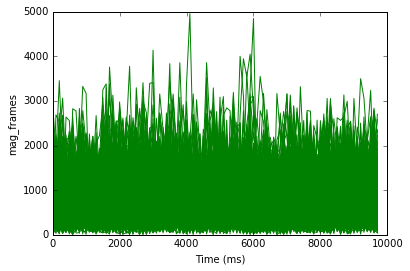

(98,)


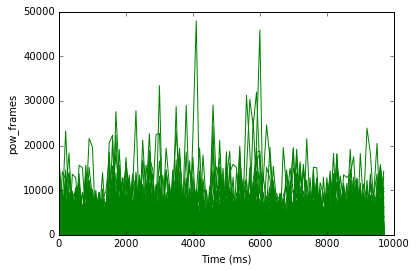

In [9]:
'''
We can now do an N-point FFT on each frame to calculate the frequency spectrum, which is also called Short-Time Fourier-Transform (STFT), where N
N is typically 256 or 512, NFFT = 512; and then compute the power spectrum (periodogram) using the following equation:
'''
NFFT = 512
mag_frames = numpy.absolute(numpy.fft.rfft(frames, NFFT))  # Magnitude of the FFT
pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))  # Power Spectrum

print mag_frames.shape
print pow_frames.shape

n=float(mag_frames.shape[0]) 
time= numpy.arange(0, n, 1)
#time = time /600
time = time * 100
print time.shape
plot(time,mag_frames,"mag_frames")


n=float(pow_frames.shape[0]) 
time= numpy.arange(0, n, 1)
#time = time /600
time = time * 100
print time.shape
plot(time,pow_frames,"pow_frames")

(98, 40)
(98,)


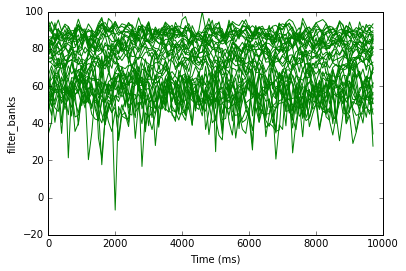

In [11]:
nfilt = 40
low_freq_mel = 0
high_freq_mel = (2595 * numpy.log10(1 + (sample_rate / 2) / 700))  # Convert Hz to Mel
mel_points = numpy.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
bin = numpy.floor((NFFT + 1) * hz_points / sample_rate)

fbank = numpy.zeros((nfilt, int(numpy.floor(NFFT / 2 + 1))))
for m in range(1, nfilt + 1):
    f_m_minus = int(bin[m - 1])   # left
    f_m = int(bin[m])             # center
    f_m_plus = int(bin[m + 1])    # right

    for k in range(f_m_minus, f_m):
        fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
    for k in range(f_m, f_m_plus):
        fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
filter_banks = numpy.dot(pow_frames, fbank.T)
filter_banks = numpy.where(filter_banks == 0, numpy.finfo(float).eps, filter_banks)  # Numerical Stability
filter_banks = 20 * numpy.log10(filter_banks)  # dB
print filter_banks.shape

n=float(filter_banks.shape[0]) 
time= numpy.arange(0, n, 1)
#time = time /600
time = time * 100
print time.shape
plot(time,filter_banks,"filter_banks")

In [12]:
num_ceps = 12
mfcc = dct(filter_banks, type=2, axis=1, norm='ortho')[:, 1 : (num_ceps + 1)] # Keep 2-13
(nframes, ncoeff) = mfcc.shape
n = numpy.arange(ncoeff)
lift = 1 + (cep_lifter / 2) * numpy.sin(numpy.pi * n / cep_lifter)
mfcc *= lift  #*

NameError: name 'cep_lifter' is not defined